# Исследовательский анализ данных

In [1]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
random.seed(42)

In [3]:
df_labels = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
display_images = df_labels.sample(10)
display_images

,file_name,real_age
2746,002746.jpg,48
2894,002894.jpg,41
6845,006854.jpg,31
1112,001112.jpg,30
198,000198.jpg,17
1817,001817.jpg,38
6361,006365.jpg,21
886,000886.jpg,29
3997,003997.jpg,34
2703,002703.jpg,19


<AxesSubplot:>

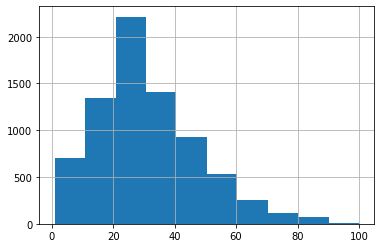

In [5]:
df_labels.real_age.hist()

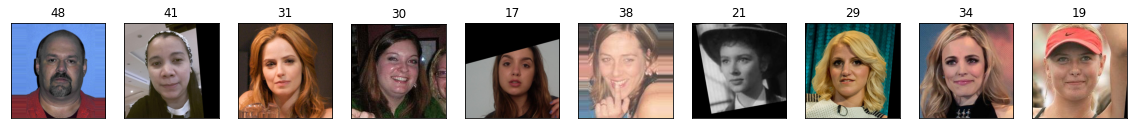

In [6]:
# Create a figure and axes
fig, axes = plt.subplots(ncols=len(display_images), figsize=(20,20))

# Adjust the spacing between plots
plt.subplots_adjust(hspace=1)  # Increase the value to add more space

# Iterate over the data and plot on each axes
for i, ax in enumerate(axes):
    image_data = display_images.iloc[i]
    image = Image.open('/datasets/faces/final_files/' + image_data.file_name)
    image_array = np.array(image)
    ax.imshow(image_array)
    
    # Hide X and Y axes label marks
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    
    # Hide X and Y axes tick marks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Display real age
    ax.set_title(image_data.real_age)

# Display the figure
plt.show()

Из этих данных, я бы сказал что не стоит делать аугментацию по сдвигу картинки. 9 картинка уже смещена максимально.

In [7]:
resolution_x = []
resolution_y = []
for file_name in df_labels.sample(100).file_name:
    image = Image.open('/datasets/faces/final_files/' + file_name)
    image_array = np.array(image)
    resolution_x.append(image_array.shape[0])
    resolution_y.append(image_array.shape[1])

(array([43., 22., 17., 12.,  3.,  2.,  0.,  0.,  0.,  1.]),
 array([  93.,  313.,  533.,  753.,  973., 1193., 1413., 1633., 1853.,
        2073., 2293.]),
 <BarContainer object of 10 artists>)

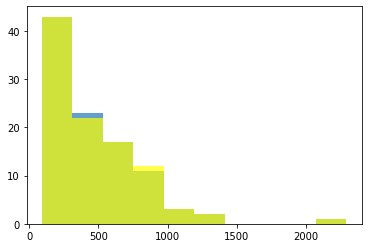

In [8]:
plt.hist(resolution_x, alpha=0.7)
plt.hist(resolution_y, alpha=0.7, color='yellow')

(array([0., 0., 0., 7., 7., 9., 6., 2., 5., 3.]),
 array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.]),
 <BarContainer object of 10 artists>)

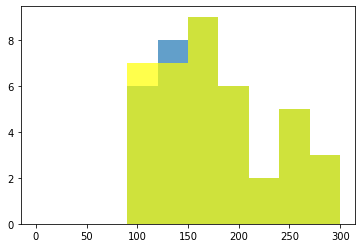

In [9]:
plt.hist(resolution_x, alpha=0.7, range=(0, 300))
plt.hist(resolution_y, alpha=0.7, color='yellow', range=(0, 300))

Я пытался какой понять какой устонавливать target_size. Похоже, что если мы укажем (128, 128), то большинство фоток будут проходить downscale, что лучше чем upscale.

# Обучение Модели

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
 
 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
 
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
 
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

In [ ]:
# Train for 356 steps, validate for 119 steps
# Epoch 1/20
# 2023-05-13 23:51:23.373032: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
# 2023-05-13 23:51:26.788173: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
# 356/356 - 66s - loss: 218.2282 - mae: 11.1202 - val_loss: 439.0421 - val_mae: 15.9026
# Epoch 2/20
# 356/356 - 38s - loss: 138.2867 - mae: 9.0037 - val_loss: 260.2313 - val_mae: 12.1413
# Epoch 3/20
# 356/356 - 38s - loss: 119.3201 - mae: 8.3469 - val_loss: 125.6413 - val_mae: 8.6252
# Epoch 4/20
# 356/356 - 38s - loss: 97.3887 - mae: 7.4579 - val_loss: 106.2981 - val_mae: 7.7837
# Epoch 5/20
# 356/356 - 38s - loss: 78.6120 - mae: 6.7858 - val_loss: 125.6724 - val_mae: 8.1406
# Epoch 6/20
# 356/356 - 38s - loss: 69.4662 - mae: 6.4126 - val_loss: 122.7081 - val_mae: 8.2926
# Epoch 7/20
# 356/356 - 38s - loss: 56.4432 - mae: 5.7588 - val_loss: 122.2632 - val_mae: 8.4438
# Epoch 8/20
# 356/356 - 38s - loss: 52.8105 - mae: 5.6046 - val_loss: 125.9086 - val_mae: 8.8149
# Epoch 9/20
# 356/356 - 38s - loss: 42.2040 - mae: 5.0149 - val_loss: 136.9023 - val_mae: 8.7750
# Epoch 10/20
# 356/356 - 38s - loss: 36.9834 - mae: 4.7275 - val_loss: 110.8054 - val_mae: 8.2654
# Epoch 11/20
# 356/356 - 38s - loss: 31.2521 - mae: 4.2951 - val_loss: 104.8969 - val_mae: 7.7202
# Epoch 12/20
# 356/356 - 38s - loss: 26.6264 - mae: 3.9781 - val_loss: 107.6240 - val_mae: 7.7912
# Epoch 13/20
# 356/356 - 38s - loss: 26.1335 - mae: 3.9528 - val_loss: 87.5318 - val_mae: 7.1315
# Epoch 14/20
# 356/356 - 38s - loss: 22.8224 - mae: 3.6848 - val_loss: 83.0108 - val_mae: 6.9403
# Epoch 15/20
# 356/356 - 38s - loss: 22.8847 - mae: 3.6637 - val_loss: 106.0527 - val_mae: 7.5512
# Epoch 16/20
# 356/356 - 38s - loss: 20.4456 - mae: 3.4843 - val_loss: 93.4487 - val_mae: 7.4809
# Epoch 17/20
# 356/356 - 38s - loss: 20.4414 - mae: 3.4834 - val_loss: 81.7102 - val_mae: 6.8075
# Epoch 18/20
# 356/356 - 38s - loss: 16.6757 - mae: 3.1849 - val_loss: 79.7337 - val_mae: 6.6395
# Epoch 19/20
# 356/356 - 38s - loss: 16.0886 - mae: 3.0844 - val_loss: 79.6142 - val_mae: 6.6707
# Epoch 20/20
# 356/356 - 38s - loss: 16.3017 - mae: 3.1100 - val_loss: 74.1686 - val_mae: 6.3470
# WARNING:tensorflow:sample_weight modes were coerced from
#   ...
#     to  
#   ['...']
# 119/119 - 9s - loss: 74.1686 - mae: 6.3470
# Test MAE: 6.3470

В тренажере рекоммендовалось получить MAE лучше чем 7, чего эта модель добилась. </br>
Моя стратегия для архитектуры модели. </br>
- Два ImageDataGenerator, один с аугментацией для тренировочной выборки.
- Исползуем ResNet50 с уже обученными нейронами.
- Менаям последний слой чтобы модель работала на линенйной регрессии.